In [ ]:
# ===============================
# 0. 라이브러리 임포트 및 경로 설정
# ===============================
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from tqdm import tqdm

# OS에 따른 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경
    plt.rc('font', family='Malgun Gothic')
else: # 그 외 리눅스 환경 (Colab 등)
    plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 경로 설정
DATA_ROOT = '/data/ephemeral/home/data/train'
IMAGE_ROOT = os.path.join(DATA_ROOT, 'DCM')
LABEL_ROOT = os.path.join(DATA_ROOT, 'outputs_json')

# 클래스 정의 (29개 클래스, 데이터셋 설명 참고하여 순서대로 정의 필요)
# 편의상 예시로 뼈 이름 나열 (실제 클래스 순서와 매핑 확인 필요)
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19',
    'Trapezium', 'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid',
    'Lunate', 'Triquetrum', 'Pisiform', 'Radius', 'Ulna'
]

# 클래스 ID와 색상 매핑 생성
np.random.seed(42)
CLASS_COLORS = np.random.randint(0, 255, size=(len(CLASSES), 3), dtype=np.uint8)


이미지 크기: (2048, 2048, 3)
포함된 뼈 개수: 29


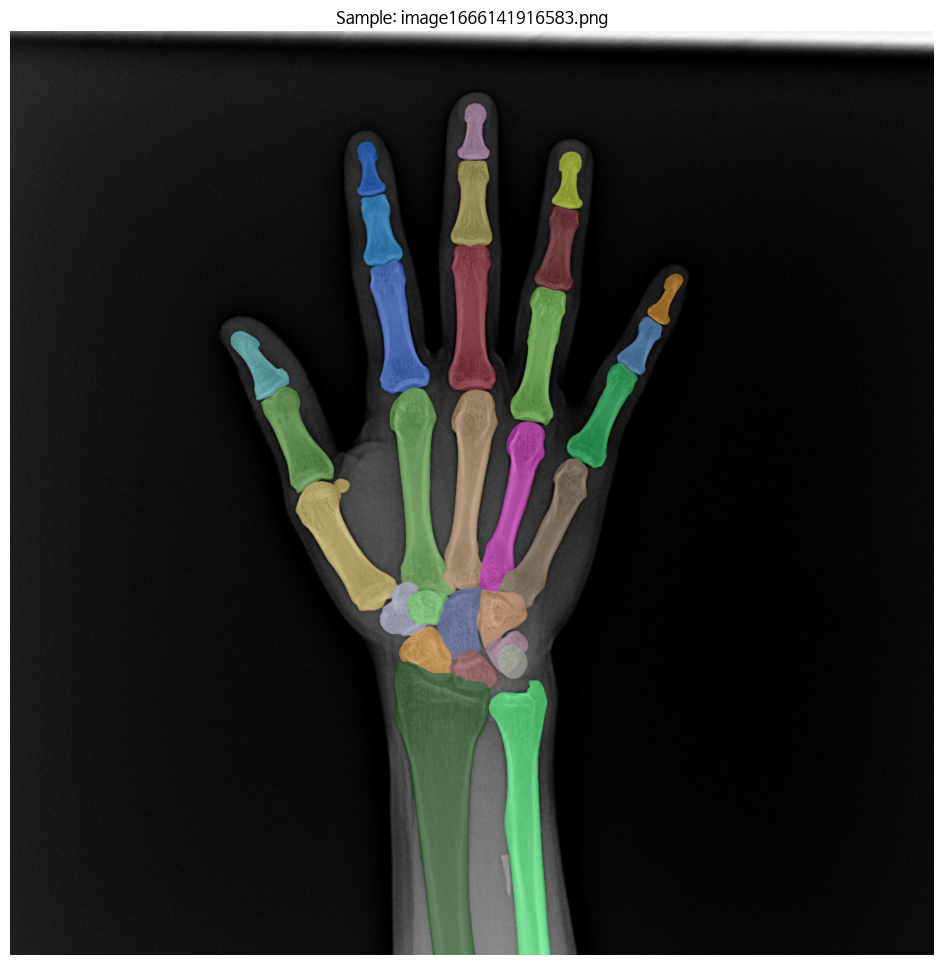

In [2]:
# ======================================
# 1. 데이터 시각화 (Image & Mask Overlay)
# ======================================
def get_image_label_paths(image_root, label_root):
    """이미지와 JSON 파일 경로 쌍을 생성합니다."""
    image_paths = glob.glob(os.path.join(image_root, '**', '*.png'), recursive=True)
    pairs = []
    for img_path in image_paths:
        # 경로에서 ID와 파일명 추출하여 JSON 경로 매칭
        rel_path = os.path.relpath(img_path, image_root)
        json_path = os.path.join(label_root, rel_path.replace('.png', '.json'))
        if os.path.exists(json_path):
            pairs.append((img_path, json_path))
    return pairs

def visualize_sample(image_path, json_path, alpha=0.5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay = img.copy()
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # JSON 구조에 따라 'annotations' 키 내부에 정보가 있다고 가정
    # 실제 데이터 구조: annotations 리스트 안에 label과 points가 존재
    annotations = data.get('annotations', [])
    
    print(f"이미지 크기: {img.shape}")
    print(f"포함된 뼈 개수: {len(annotations)}")

    for ann in annotations:
        label_name = ann['label']
        try:
            class_idx = CLASSES.index(label_name)
        except ValueError:
            continue # 정의되지 않은 클래스 패스
            
        points = np.array(ann['points'])
        cv2.fillPoly(overlay, [points], color=CLASS_COLORS[class_idx].tolist())
        
        # 중심점에 텍스트 표시 (선택사항)
        # M = cv2.moments(points)
        # if M['m00'] != 0:
        #     cX = int(M['m10'] / M['m00'])
        #     cY = int(M['m01'] / M['m00'])
        #     cv2.putText(overlay, str(class_idx), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # 이미지 블렌딩
    vis_img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(vis_img)
    plt.title(f"Sample: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# 실행
pairs = get_image_label_paths(IMAGE_ROOT, LABEL_ROOT)
if pairs:
    visualize_sample(pairs[0][0], pairs[0][1])
else:
    print("데이터를 찾을 수 없습니다. 경로를 확인해주세요.")

100%|██████████| 300/300 [00:01<00:00, 181.40it/s]
/tmp/ipykernel_61011/1051655268.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Avg Area', data=df_area, palette='viridis')


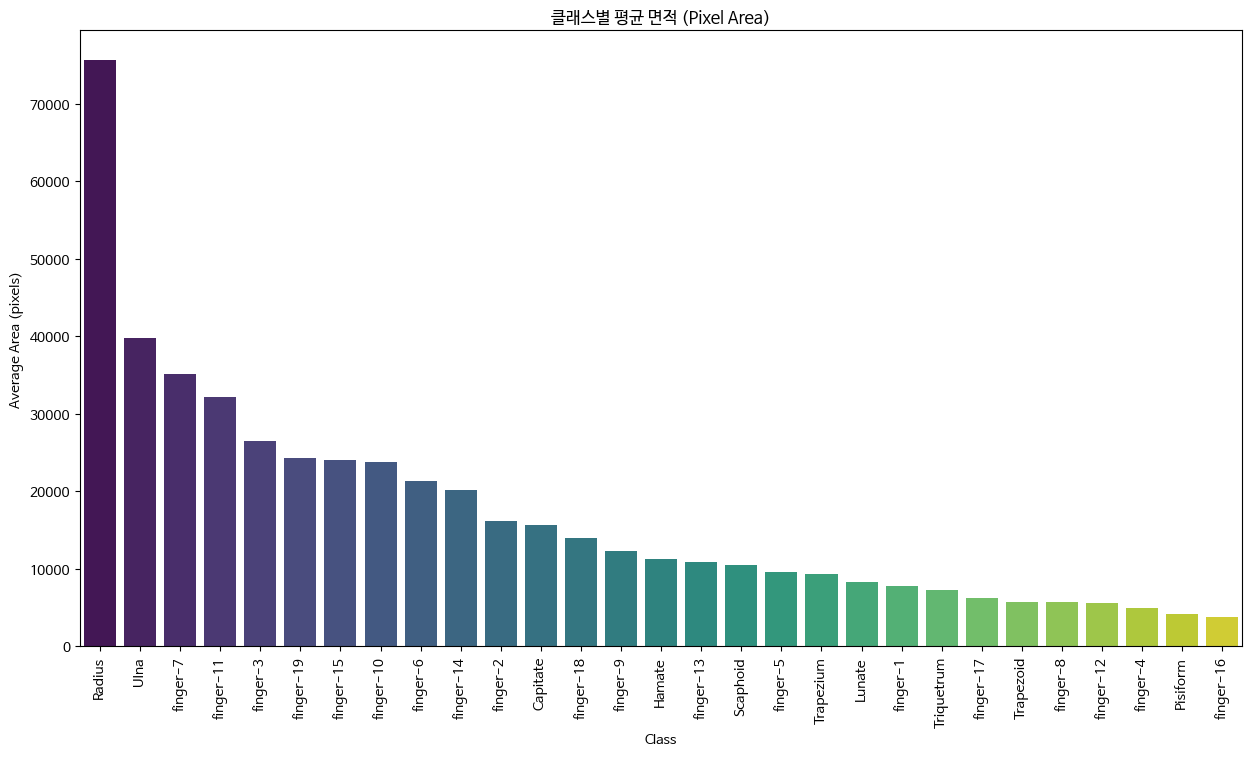

In [3]:
# ===============================================
# 2. 클래스 불균형 분석 (Class Imbalance Analysis)
# ===============================================
def analyze_class_area(pairs):
    class_areas = {cls: [] for cls in CLASSES}
    
    for _, json_path in tqdm(pairs[:300]): # 시간 관계상 300개만 샘플링 (전체 데이터 사용 권장)
        with open(json_path, 'r') as f:
            data = json.load(f)
            
        annotations = data.get('annotations', [])
        for ann in annotations:
            label_name = ann['label']
            if label_name in CLASSES:
                points = np.array(ann['points'])
                # 컨투어 면적 계산 (픽셀 단위)
                area = cv2.contourArea(points)
                class_areas[label_name].append(area)
    
    return class_areas

class_areas = analyze_class_area(pairs)

# 데이터프레임 변환 및 시각화
avg_areas = {k: np.mean(v) if v else 0 for k, v in class_areas.items()}
df_area = pd.DataFrame(list(avg_areas.items()), columns=['Class', 'Avg Area'])
df_area = df_area.sort_values(by='Avg Area', ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x='Class', y='Avg Area', data=df_area, palette='viridis')
plt.xticks(rotation=90)
plt.title("클래스별 평균 면적 (Pixel Area)")
plt.ylabel("Average Area (pixels)")
plt.show()

100%|██████████| 50/50 [00:02<00:00, 23.23it/s]


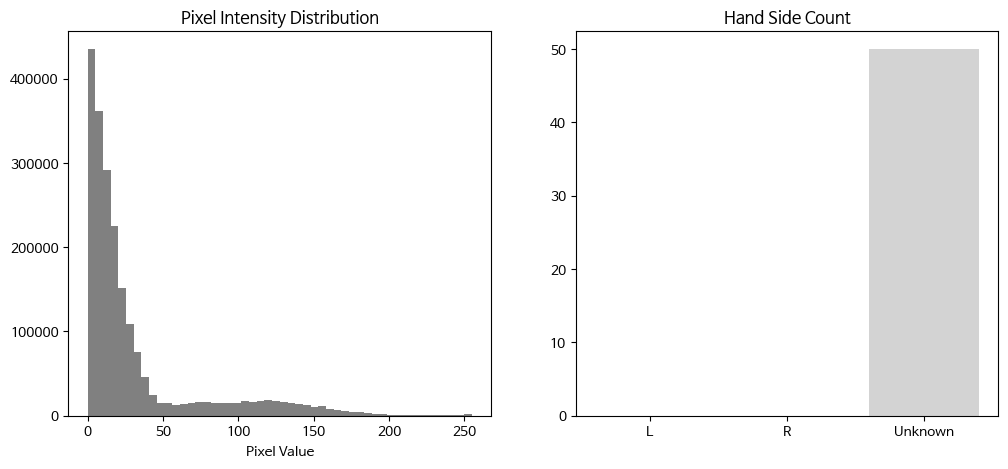

In [4]:
# ========================================================
# 3. 이미지 통계 및 메타데이터 분석 (Histogram & Left/Right)
# ========================================================
def analyze_image_stats(pairs):
    pixel_values = []
    hand_sides = {'L': 0, 'R': 0, 'Unknown': 0}
    
    # 50개 샘플로 픽셀 분포 확인
    for img_path, _ in tqdm(pairs[:50]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        pixel_values.extend(img.flatten()[::100]) # 다운샘플링하여 메모리 절약
        
        # 파일명 기반 L/R 확인 (파일명 예: image123_L.png)
        filename = os.path.basename(img_path)
        if '_L' in filename:
            hand_sides['L'] += 1
        elif '_R' in filename:
            hand_sides['R'] += 1
        else:
            hand_sides['Unknown'] += 1
            
    return np.array(pixel_values), hand_sides

pixels, sides = analyze_image_stats(pairs)

# 1. 픽셀 밝기 히스토그램
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(pixels, bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")

# 2. 왼손/오른손 비율
plt.subplot(1, 2, 2)
plt.bar(sides.keys(), sides.values(), color=['skyblue', 'salmon', 'lightgray'])
plt.title("Hand Side Count")
plt.show()


In [5]:
# ==================================
# 
# ==================================